In this notebook I will choose a small balanced fraction of the dataset to work with in AWS ML Engineer Capstone Project. I will then preprocess the images and save them.

In [1]:
import pydicom
import numpy as np
import cv2
import os
from joblib import Parallel, delayed
from tqdm.notebook import tqdm
from pathlib import Path
import pandas as pd
from pydicom.pixel_data_handlers.util import apply_voi_lut
from matplotlib import pyplot as plt
from PIL import Image

In [2]:
train_df = pd.read_csv("./train.csv")
train_df.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True


I will choose random 200 unique patients for each class (making sure the normal patients are different from the ones included in cancer

In [3]:
cancer_df = train_df.query('cancer == 1')
normal_df = train_df.query('cancer == 0')
print(cancer_df.shape, normal_df.shape)

(1158, 14) (53548, 14)


In [4]:
cancer_ids = list(cancer_df['patient_id'].unique())
normal_ids = list(normal_df['patient_id'].unique())
# remove any patient in normal that is included in cancer 
normal_ids = [normal_id for normal_id in normal_ids if normal_id not in cancer_ids]

print(len(cancer_ids), len(normal_ids))

486 11427


In [5]:
any(i in cancer_ids for i in normal_ids)

False

In [6]:
# take only 200 cases (for this I will have 4 images for each case the 2 views CC and MLO x 2 laterals)
# if any of those cases have other views I will drop them for now
cancer_ids = cancer_ids[:200]
normal_ids = normal_ids[:200]

# update our dataframes to include only the selected ids

cancer_df = train_df[train_df.apply(lambda x: x['patient_id'] in cancer_ids, axis=1)]
normal_df = train_df[train_df.apply(lambda x: x['patient_id'] in normal_ids, axis=1)]

print(cancer_df.shape, normal_df.shape)

(947, 14) (915, 14)


In [7]:
print(len(cancer_ids), len(normal_ids))

200 200


In [8]:
cancer_df.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
87,1,10130,388811999,L,MLO,71.0,1,1,1,0.0,0,B,49,False
88,1,10130,613462606,L,CC,71.0,1,1,1,0.0,0,B,49,False
89,1,10130,1360338805,L,CC,71.0,1,1,1,0.0,0,B,49,False
90,1,10130,1672636630,L,MLO,71.0,1,1,1,0.0,0,B,49,False
91,1,10130,1013166704,R,CC,71.0,0,0,0,NaN,0,B,49,False


In [9]:
# check if any views other than CC and MLO exists in our selection
cancer_df.groupby("view").count()

,site_id,patient_id,image_id,laterality,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
view,,,,,,,,,,,,,
AT,2,2,2,2,2,2,2,2,2,2,2,2,2
CC,462,462,462,462,462,462,462,462,140,462,280,462,462
MLO,483,483,483,483,483,483,483,483,150,483,300,483,483


In [10]:
normal_df.groupby("view").count()

,site_id,patient_id,image_id,laterality,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
view,,,,,,,,,,,,,
CC,443,443,443,443,443,443,443,443,200,443,227,443,443
MLO,472,472,472,472,472,472,472,472,223,472,253,472,472


In [11]:
# drop the AT view from the cancer selection
cancer_df.drop(cancer_df[cancer_df['view']=='AT'].index, inplace=True)

/home/advintic/anaconda3/envs/nEnv/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [12]:
# save the new dataframe
final_df = cancer_df.append(normal_df)
final_df.to_csv("new_train.csv")

The following cells resize the images keeping their aspect ratio, normalize, fix photometric intrepertation if neeeded, apply VOI LUT and save.
I might later look into 
1. saving as grey scale 16 bits images
2. crop background
3. remove artifacts such as labels (LCC for ex)
4. apply CLAHE preprocessing

In [14]:
RESIZE_TO = 1024

!mkdir train_images_processed
# the below helper functions are adapted from a kaggle notebook 
#https://www.kaggle.com/code/radek1/how-to-process-dicom-images-to-pngs?scriptVersionId=113529850

def image_resize(image, width = None, height = None, inter = cv2.INTER_LINEAR):

    dim = None
    (h, w) = image.shape[:2]

    if width is None and height is None:
        return image

    if width is None:
        r = height / float(h)
        dim = (int(w * r), height)
    else:
        r = width / float(w)
        dim = (width, int(h * r))
    resized = cv2.resize(image, dim, interpolation = inter)

    return resized


# https://www.kaggle.com/code/tanlikesmath/brain-tumor-radiogenomic-classification-eda/notebook
def dicom_file_to_ary(path):
    dicom = pydicom.dcmread(path)
    data = dicom.pixel_array
    data = apply_voi_lut(dicom.pixel_array, dicom)
    
    max_px = 2 ** dicom.BitsStored - 1
    data = (data - data.min()) / (max_px - data.min())
    
    if dicom.PhotometricInterpretation == "MONOCHROME1":
        data = 1 - data
    
    h, w = data.shape
    if w > h:
         data = image_resize(data, width = RESIZE_TO)
    else:
         data = image_resize(data, height = RESIZE_TO)
    
    data = (data * 255).astype(np.uint8)
    return data

#directories = list(Path('train_images').iterdir())

def process_directory(directory_path):
    parent_directory = str(directory_path).split('/')[-1]
    !mkdir -p train_images_processed/{parent_directory}
    for image_path in directory_path.iterdir():
        processed_ary = dicom_file_to_ary(image_path)
        
        cv2.imwrite(
            f'train_images_processed/{parent_directory}/{image_path.stem}.png',
            processed_ary
        )


CPU times: user 12.3 ms, sys: 3.86 ms, total: 16.2 ms
Wall time: 127 ms


In [16]:
%%time
directories = [Path(os.path.join('train_images', str(id_))) for id_ in cancer_ids] + [Path(os.path.join('train_images', str(id_))) for id_ in normal_ids]
print(len(directories))        
import multiprocessing as mp

with mp.Pool(64) as p:
    p.map(process_directory, directories)

400
CPU times: user 927 ms, sys: 1.11 s, total: 2.04 s
Wall time: 9min 28s


Let's check an example

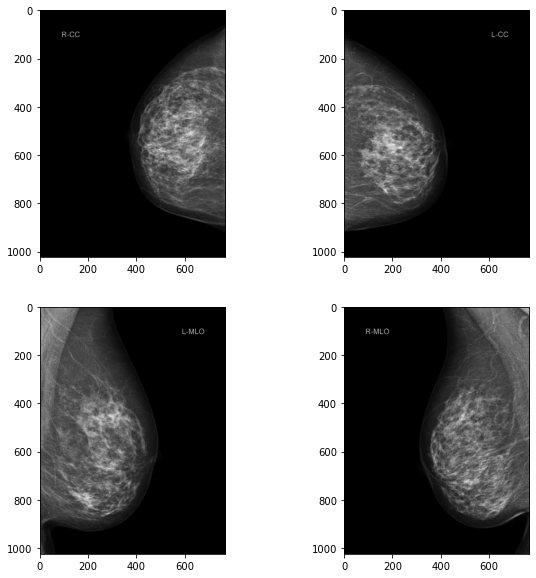

In [21]:
# cancer case
fig, axs = plt.subplots(2, 2, figsize=(10,10))
for ax, path in zip(axs.flat, Path('./train_images_processed/'+str(cancer_ids[9])).iterdir()):
    img = Image.open(path)
    ax.imshow(img, cmap="gray")

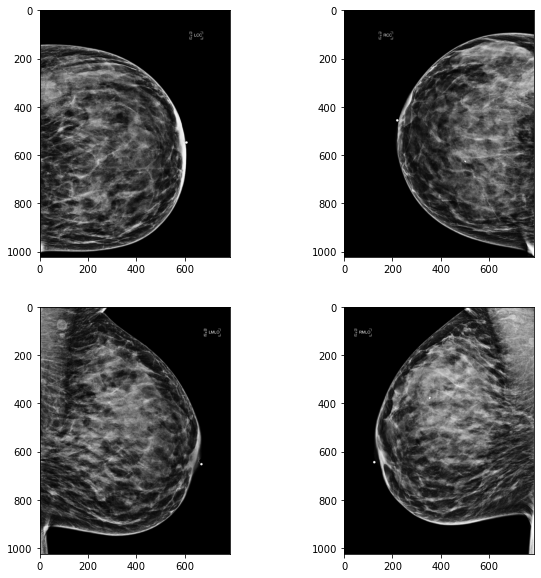

In [23]:
# normal case
fig, axs = plt.subplots(2, 2, figsize=(10,10))
for ax, path in zip(axs.flat, Path('./train_images_processed/'+str(normal_ids[10])).iterdir()):
    img = Image.open(path)
    ax.imshow(img, cmap="gray")

In [29]:
for ax, path in zip(axs.flat, Path('./train_images_processed/'+str(cancer_ids[0])).iterdir()):
    print(img.size)

(787, 1024)
(787, 1024)
(787, 1024)
(787, 1024)
